# Import Libraries

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import *
import sys, os
import random 
from IPython import display, utils
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import preprocessing
from keras.layers import AveragePooling2D, Input, Flatten 

from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LSTM, Dense, LSTM,Bidirectional

seed(2020)
set_seed(2021)
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load The Data

In [3]:
def load(df):
  """
  change the index to be period and timedelta
  """
  df['timedelta'] = pd.to_timedelta(df['timedelta'])
  df.set_index(["period", "timedelta"], inplace=True)
  print(df.shape)
  return df.head()


In [4]:
solar_wind = pd.read_csv("/content/drive/MyDrive/MEGAtronics/solar_wind.csv")
load(solar_wind)

(8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [5]:
solar_wind.groupby("period").describe()

bx_gse                                                      \
             count      mean       std    min   25%   50%   75%    max   
period                                                                   
train_a  1575012.0 -1.781301  4.339212 -54.63 -4.96 -2.01  1.55  41.13   
train_b  3084130.0 -0.308879  3.627830 -29.37 -3.07 -0.45  2.42  25.07   
train_c  3407290.0 -0.461908  3.245485 -45.46 -2.80 -0.42  1.87  55.55   

            by_gse            ...   speed          temperature                 \
             count      mean  ...     75%      max       count           mean   
period                        ...                                               
train_a  1575012.0  0.406389  ...  484.13  1011.50   1396624.0  105917.432742   
train_b  3084130.0  0.159068  ...  481.95  1198.49   3036895.0  136424.705063   
train_c  3407290.0 -0.071924  ...  490.60  1064.00   3147033.0   98588.925913   

                                                                        
                   std      min      25%      50%       75%        max  
period                                                                  
train_a  100098.319077  10000.0  43649.0  79238.0  132550.0  6223700.0  
train_b  149788.503256   1496.0  37414.0  85524.0  187325.0  4206672.0  
train_c   89556.600276      0.0  40074.0  71521.0  131088.0  5751308.0  

[3 rows x 112 columns]

In [6]:
labels_df = pd.read_csv("/content/drive/MyDrive/MEGAtronics/labels.csv")
load(labels_df)

(139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [7]:
labels_df.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [8]:
sunspots = pd.read_csv("/content/drive/MyDrive/MEGAtronics/sunspots.csv")
load(sunspots)

(192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [9]:
sunspots.groupby("period").describe()

smoothed_ssn                                                        \
               count       mean        std   min      25%     50%      75%   
period                                                                       
train_a         40.0  136.90250  34.563168  65.4  108.375  151.50  164.400   
train_b         72.0   51.85000  39.200266   3.9   15.325   43.15   91.225   
train_c         80.0   24.31375  19.020414   2.2    7.775   20.50   38.525   

                
           max  
period          
train_a  175.2  
train_b  116.4  
train_c   69.5

# Exploratory data analysis (EDA)

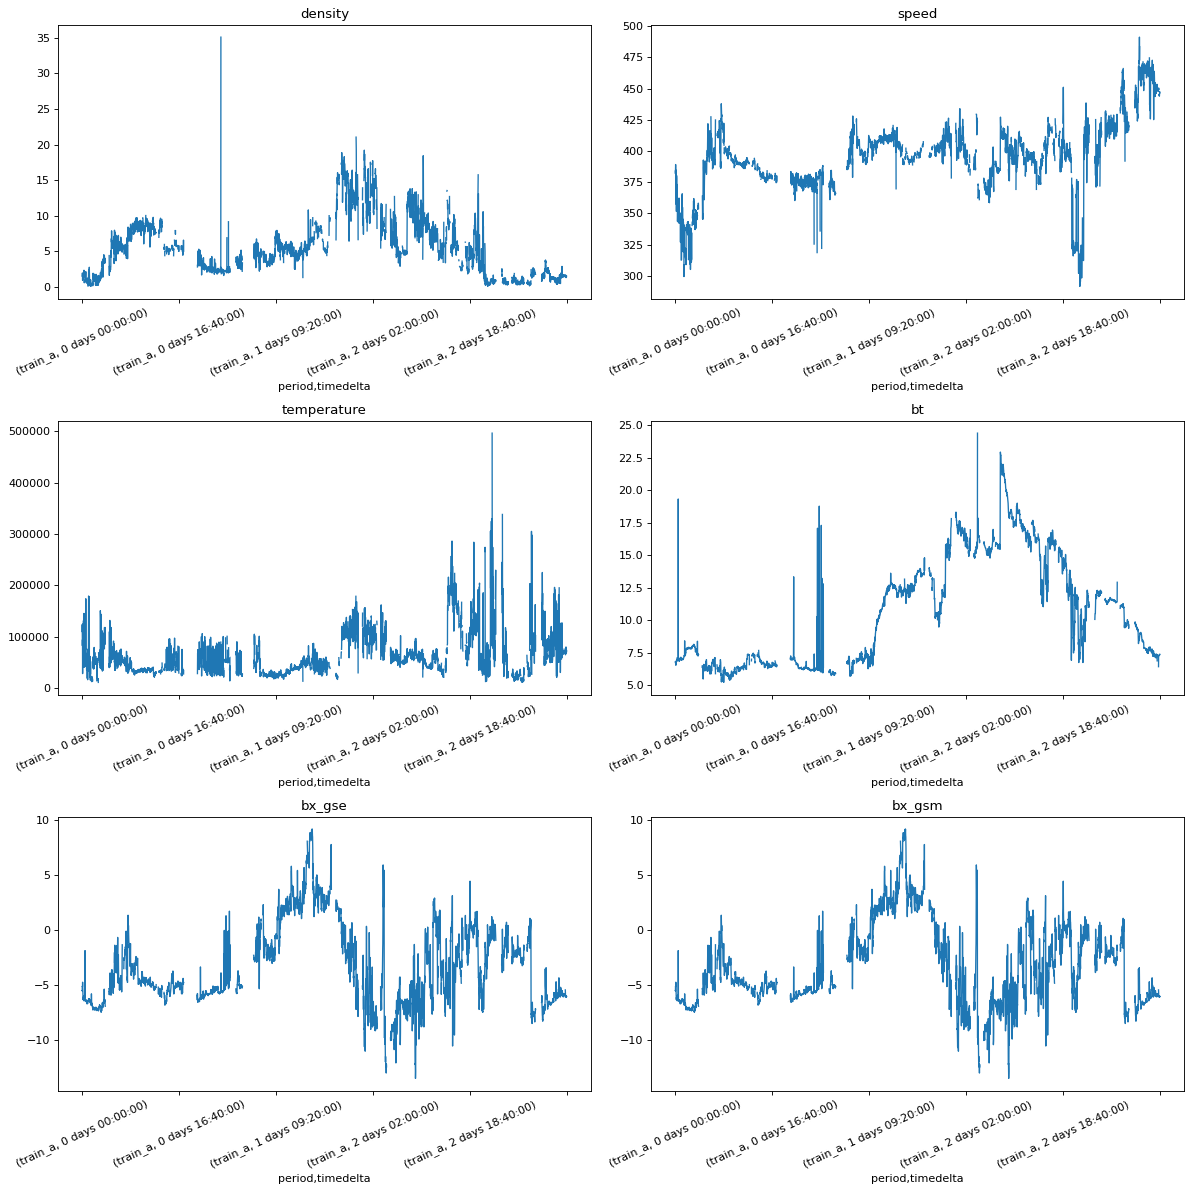

In [10]:
columns = ["density" , "speed" , "temperature" , "bt" , "bx_gse" , "bx_gsm"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
for i, key in enumerate(solar_wind[columns].iloc[:1000].columns):
    t_data = solar_wind[columns].iloc[:5000][key]
    ax = t_data.plot( ax=axes[i // 2, i % 2], title=f"{key}", rot=25, lw=1.2 )

fig.subplots_adjust(hspace=0.8)
plt.tight_layout()

In [11]:
solar_wind.isnull().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

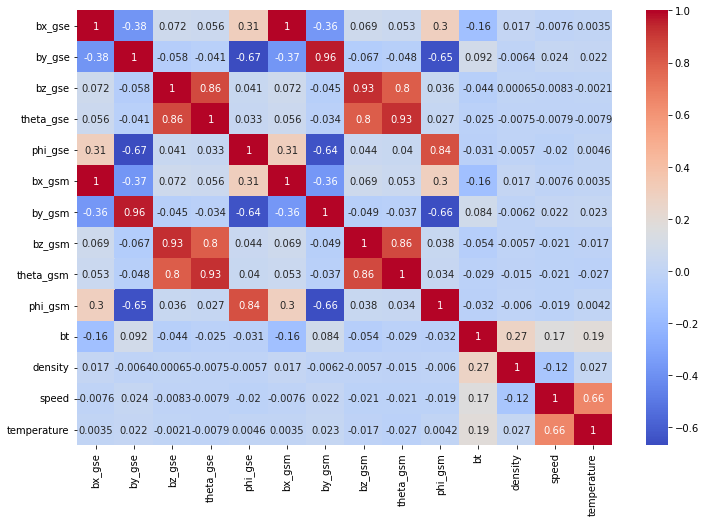

In [12]:
# heatmap of correlation matrix
corr = solar_wind.corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")


# Handling Data

In [13]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = ["bt" , "bx_gse" , "by_gse" , "bz_gse" , "temperature" , "speed" , "density"]

# all of the features we'll use, including sunspot numbers
XCOLS = ( [col + "_mean" for col in SOLAR_WIND_FEATURES] + [col + "_std" for col in SOLAR_WIND_FEATURES] + ["smoothed_ssn"] )

In [14]:
#@title implemented Functions
def convert_minutes_to__hours(new_df, aggs=["mean", "std"]):
    """
    Utilizing the mean and standard deviation, aggregates features to the hourly floor.
    For instance, "10:00:00" will be the total of all values from "10:00:00" to "10:59:00."
    ----------
    input: 1- data frame in minutes
    ----------
    return: 1- data frame in hours
    """
    # group by the floor of each hour use timedelta index
    aggregated = new_df.groupby(
        ["period", new_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    aggregated.columns = ["_".join(x) for x in aggregated.columns]
    return aggregated

def new_features(new_df):
    """Imputes data using the following methods:
    - `solar_wind`: interpolation
    - `smoothed_ssn`: forward fill
    """
    # forward fill sunspot data for the rest of the month
    new_df['smoothed_ssn'] = new_df['smoothed_ssn'].fillna(method="ffill")
    # interpolate between missing solar wind values
    new_df = new_df.interpolate()
    return new_df


def preprocessing(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - take Subset from the data
        - Aggregate hourly
        - Join  sunspot data and solar wind
        - Scale using standard scaler
        - Impute missing values
        ----------
    inputs : 1- solar_wind 2- sunspots 3- scaler(default = None) 4-subset(default = None)
    ----------
    return: 1- imputed(data frame) 2-scaler
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = convert_minutes_to__hours(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = new_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


def process_labels(dst):
    """
    To predict current time(now) and next time(future), we creadted second column for (future)
    ----------
    inputs : 1- dst(labels data)
    ----------
    return: 1- y(labels data with additional column (future) )

    """
    YCOLS = ["now", "future"]

    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y

def timeseries_dataset_from_df(df, batch_size, timesteps):
    """
    Concatenate different time periods & create desired timesteps for inputs and outputs
    ----------
    inputs : 1- data frame 2- batch_size 3- timesteps 
    ----------
    return: 1- dataset(data frame)
    """

    dataset = None


    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

def predict_dst(
    solar_wind_7d: pd.DataFrame,
    latest_sunspot_number: float):
  
    """
    Make predictions for times t and t+1 using all of the data up to time t-1.
    Parameters
    ----------
    inputs :
    1- solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    2- latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    -------
    Returns :
    predictions : Tuple[float, float]
    A tuple of two forecasts for (now) and (future), respectively
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number

    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocessing(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    timesteps = data_config["timesteps"]
    batch_size= data_config["batch_size"]

    model_input = features[XCOLS][-timesteps:].values.reshape( (1, timesteps, features.shape[1]))


    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

In [15]:
preprocessed, scaler = preprocessing(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(preprocessed.shape)
preprocessed.head()

(139872, 15)


bt_mean    bt_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                      
train_a 0 days 00:00:00  0.499705  2.443614    -1.599207   -0.381502   
        0 days 01:00:00  0.547177 -0.224580    -1.757995   -0.867747   
        0 days 02:00:00  0.739905 -0.770240    -1.912116   -1.114317   
        0 days 03:00:00  0.699098 -0.278783    -1.809045   -0.783042   
        0 days 04:00:00  0.223933 -0.225168    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         temperature_mean  temperature_std  speed_mean  \
period  timedelta                                                        
train_a 0 days 00:00:00         -0.375267         0.383941   -0.738546   
        0 days 01:00:00         -0.479430         0.953178   -0.986904   
        0 days 02:00:00         -0.574831        -0.192518   -1.013548   
        0 days 03:00:00         -0.324709         0.325491   -0.826469   
        0 days 04:00:00         -0.313432         0.201600   -0.601238   

                         speed_std  density_mean  density_std  smoothed_ssn  
period  timedelta                                                            
train_a 0 days 00:00:00   0.862524     -0.775827    -0.205724      0.139444  
        0 days 01:00:00   0.995063     -0.861692    -0.058215      0.139444  
        0 days 02:00:00   0.554085     -0.846222    -0.220012      0.139444  
        0 days 03:00:00  -0.211185     -0.404306     0.218373      0.139444  
        0 days 04:00:00   1.016033     -0.371487     0.097253      0.139444

In [16]:
assert (preprocessed.isna().sum() == 0).all()

In [17]:
YCOLS = ["now", "future"]

labels = process_labels(labels_df)
labels.head()

now  future
period  timedelta                   
train_a 0 days 00:00:00   -7   -10.0
        0 days 01:00:00  -10   -10.0
        0 days 02:00:00  -10    -6.0
        0 days 03:00:00   -6    -2.0
        0 days 04:00:00   -2     3.0

In [18]:
data = labels.join(preprocessed)
data.head()

now  future   bt_mean    bt_std  bx_gse_mean  \
period  timedelta                                                       
train_a 0 days 00:00:00   -7   -10.0  0.499705  2.443614    -1.599207   
        0 days 01:00:00  -10   -10.0  0.547177 -0.224580    -1.757995   
        0 days 02:00:00  -10    -6.0  0.739905 -0.770240    -1.912116   
        0 days 03:00:00   -6    -2.0  0.699098 -0.278783    -1.809045   
        0 days 04:00:00   -2     3.0  0.223933 -0.225168    -1.338802   

                         bx_gse_std  by_gse_mean  by_gse_std  bz_gse_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.381502     0.419516    0.031658     0.300358   
        0 days 01:00:00   -0.867747     0.179257   -0.272971     0.446103   
        0 days 02:00:00   -1.114317     0.183266   -0.822786     0.770174   
        0 days 03:00:00   -0.783042    -0.378111    0.341156     0.621194   
        0 days 04:00:00   -0.484910     0.072745    1.023019     0.467629   

                         bz_gse_std  temperature_mean  temperature_std  \
period  timedelta                                                        
train_a 0 days 00:00:00   -0.651645         -0.375267         0.383941   
        0 days 01:00:00   -0.517913         -0.479430         0.953178   
        0 days 02:00:00   -0.876490         -0.574831        -0.192518   
        0 days 03:00:00   -0.290211         -0.324709         0.325491   
        0 days 04:00:00   -0.478080         -0.313432         0.201600   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

# Split The Data

In [19]:
test = data.groupby("period").tail(6000)
zz = data[~data.index.isin(test.index)]
val = data.groupby("period").tail(3000)
train = zz[~zz.index.isin(val.index)]


In [20]:
data_config = { "timesteps": 34, "batch_size": 34}
timesteps = data_config["timesteps"]
batch_size= data_config["batch_size"]

In [21]:
train_ds = timeseries_dataset_from_df(train, data_config["batch_size"], data_config["timesteps"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"], data_config["timesteps"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3581
Number of val batches: 261


# Bulid The Model

In [23]:
# define our model
model_config = {"n_epochs": 20, "n_neurons": 250, "dropout": 0.1 , "stateful": False}


model = Sequential()
model.add(Input(shape=(data_config["timesteps"],
                             len(XCOLS))))
model.add(Bidirectional(LSTM(model_config["n_neurons"],
                             batch_input_shape=(None, data_config["timesteps"],
                             len(XCOLS)),stateful=model_config["stateful"],
                             dropout=model_config["dropout"],return_sequences=True)))

model.add(Bidirectional(LSTM(128,
                             batch_input_shape=(None, data_config["timesteps"],
                             len(XCOLS)),stateful=model_config["stateful"],
                             dropout=model_config["dropout"],return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.1)))

model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.1)))
model.add(Dense(8))
model.add(Dense(len(YCOLS)))


model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 34, 500)          532000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 34, 256)          644096    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 34, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 8)                 2

In [24]:
history = model.fit( train_ds , 
                    batch_size=data_config["batch_size"] ,
                    epochs=model_config["n_epochs"] ,
                    verbose=1,
                    shuffle=False,
                    validation_data=val_ds
)

Epoch 1/20
3581/3581 [==============================] - 127s 32ms/step - loss: 298.1564 - val_loss: 579.9250
Epoch 2/20
3581/3581 [==============================] - 110s 31ms/step - loss: 239.0160 - val_loss: 462.6293
Epoch 3/20
3581/3581 [==============================] - 111s 31ms/step - loss: 247.2221 - val_loss: 462.0959
Epoch 4/20
3581/3581 [==============================] - 110s 31ms/step - loss: 213.9211 - val_loss: 401.9196
Epoch 5/20
3581/3581 [==============================] - 114s 32ms/step - loss: 186.5499 - val_loss: 418.2870
Epoch 6/20
3581/3581 [==============================] - 121s 34ms/step - loss: 168.8914 - val_loss: 337.0367
Epoch 7/20
3581/3581 [==============================] - 116s 32ms/step - loss: 159.2370 - val_loss: 298.7615
Epoch 8/20
3581/3581 [==============================] - 115s 32ms/step - loss: 144.0728 - val_loss: 271.9898
Epoch 9/20
3581/3581 [==============================] - 113s 32ms/step - loss: 140.1178 - val_loss: 298.7616
Epoch 10/20
3581/35

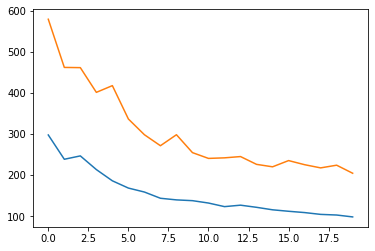

In [25]:
 for name, values in history.history.items():
    plt.plot(values)

In [26]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"],data_config["timesteps"])
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

525/525 [==============================] - 8s 14ms/step - loss: 161.9143
Test RMSE: 12.72


In [27]:
model.save("model")


# Prediction

In [30]:
solar_wind_last7= solar_wind.tail(10080)
latest_sunspot_number = 42.5

In [31]:
predict_dst(solar_wind_last7,latest_sunspot_number)

(-14.594156, -13.866098)